### This notebook compares 2 runs

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

In [2]:
case1 = 'g.e21.G1850ECOIAF.T62_g16.001'
case2 = 'g.e21.G1850ECOIAF.T62_g16.004'
path1 = '/glade/scratch/kristenk/archive/' + case1 + '/ocn/proc/tseries/month_1'
path2 = '/glade/scratch/kristenk/archive/' + case2 + '/ocn/proc/tseries/month_1'

In [3]:
variables = ['NO3', 'PO4','AOU','O2','SiO3']

In [4]:
coords = {'x':'TLONG','y':'TLAT'}

In [5]:
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time'] + variables

In [6]:
%%time

ds_list = []

print(f'reading {case1}')

ds1 = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path1}/{case1}.pop.h.{v}.??????-??????.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds1 = xr.merge((ds1, dsv))
    ds_list.append(ds1)

reading g.e21.G1850ECOIAF.T62_g16.001
NO3
PO4
AOU
O2
SiO3
CPU times: user 2.51 s, sys: 381 ms, total: 2.89 s
Wall time: 5.23 s


In [7]:
%%time

ds_list = []

print(f'reading {case2}')

ds2 = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path2}/{case2}.pop.h.{v}.??????-??????.nc'))       

    #print(files)
    
    #dsv = xr.open_mfdataset(files, decode_times=True, decode_coords=False)
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds2 = xr.merge((ds2, dsv))
    ds_list.append(ds2)

reading g.e21.G1850ECOIAF.T62_g16.004
NO3
PO4
AOU
O2
SiO3
CPU times: user 2.56 s, sys: 208 ms, total: 2.77 s
Wall time: 5.1 s


In [8]:
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds1 = ds1.drop([v for v in ds1.variables if v not in keep_vars])
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars])

In [9]:
ds1["time"] = ds1.time_bound.compute().mean(dim="d2")
ds2["time"] = ds2.time_bound.compute().mean(dim="d2")

In [10]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds1.z_t
tlen=len(ds1.time)
tlen

1488

calcs for maps

In [11]:
ds1_annmean = xr.Dataset()
ds1_annmean['NO3'] = ds1.NO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['PO4'] = ds1.PO4.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['SiO3'] = ds1.SiO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['AOU'] = ds1.AOU.isel(time=slice(-120,tlen)).mean(dim='time')
ds1_annmean['O2'] = ds1.O2.isel(time=slice(-120,tlen)).mean(dim='time')

In [12]:
ds2_annmean = xr.Dataset()
ds2_annmean['NO3'] = ds2.NO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['PO4'] = ds2.PO4.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['SiO3'] = ds2.SiO3.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['AOU'] = ds2.AOU.isel(time=slice(-120,tlen)).mean(dim='time')
ds2_annmean['O2'] = ds2.O2.isel(time=slice(-120,tlen)).mean(dim='time')

calcs for profiles

In [32]:
ds1_glb = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_glb['NO3']= esmlab.weighted_mean(ds1_annmean['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['PO4']= esmlab.weighted_mean(ds1_annmean['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['O2']= esmlab.weighted_mean(ds1_annmean['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_glb['AOU']= esmlab.weighted_mean(ds1_annmean['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [33]:
ds2_glb = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds2_glb['NO3']= esmlab.weighted_mean(ds2_annmean['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['PO4']= esmlab.weighted_mean(ds2_annmean['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['O2']= esmlab.weighted_mean(ds2_annmean['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds2_glb['AOU']= esmlab.weighted_mean(ds2_annmean['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [34]:
ds_glb_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_glb_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['O2'] = esmlab.weighted_mean(ds_woa['O2'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_glb_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU'], weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [18]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

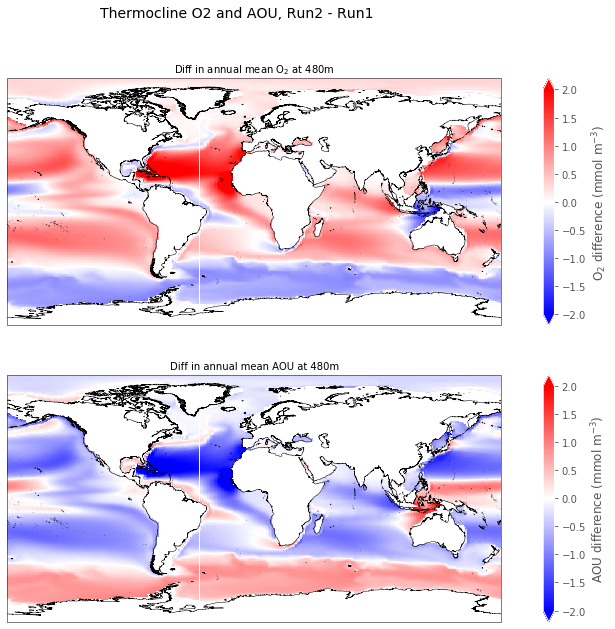

In [28]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Thermocline O2 and AOU, Run2 - Run1', fontsize=14)

#COLUMN 1  - O2 diff
#---- 
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean O$_2$ at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.O2.isel(z_t=32)-ds1_annmean.O2.isel(z_t=32),cmap='bwr',
                 vmin=-2, vmax=2, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='O$_2$ difference (mmol m$^{-3}$)')

#----  AOU diff
ax = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean AOU at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.AOU.isel(z_t=32)-ds1_annmean.AOU.isel(z_t=32), cmap='bwr',
                 vmin=-2, vmax=2, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='AOU difference (mmol m$^{-3}$)')


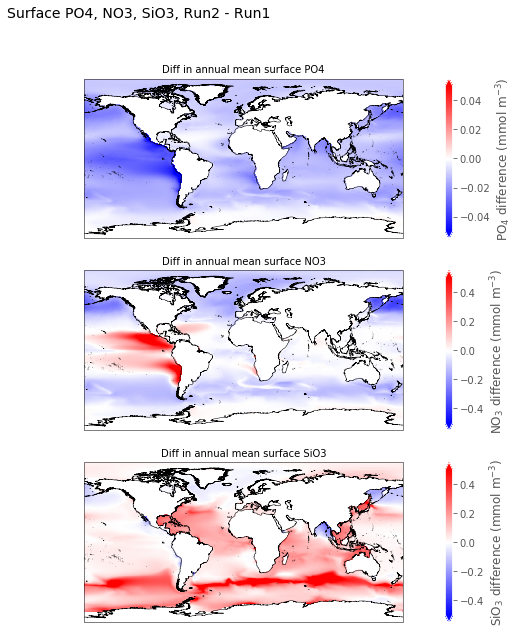

In [29]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Surface PO4, NO3, SiO3, Run2 - Run1', fontsize=14)

#COLUMN 1  - PO4 diff
#---- 
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface PO4', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.PO4.isel(z_t=0)-ds1_annmean.PO4.isel(z_t=0),cmap='bwr',
                 vmin=-0.05, vmax=0.05, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='PO$_4$ difference (mmol m$^{-3}$)')

#----  NO3 diff
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface NO3', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.NO3.isel(z_t=0)-ds1_annmean.NO3.isel(z_t=0), cmap='bwr',
                 vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='NO$_3$ difference (mmol m$^{-3}$)')

#----  SiO3 diff
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean surface SiO3', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.SiO3.isel(z_t=0)-ds1_annmean.SiO3.isel(z_t=0), cmap='bwr',
                 vmin=-0.5, vmax=0.5, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='SiO$_3$ difference (mmol m$^{-3}$)')

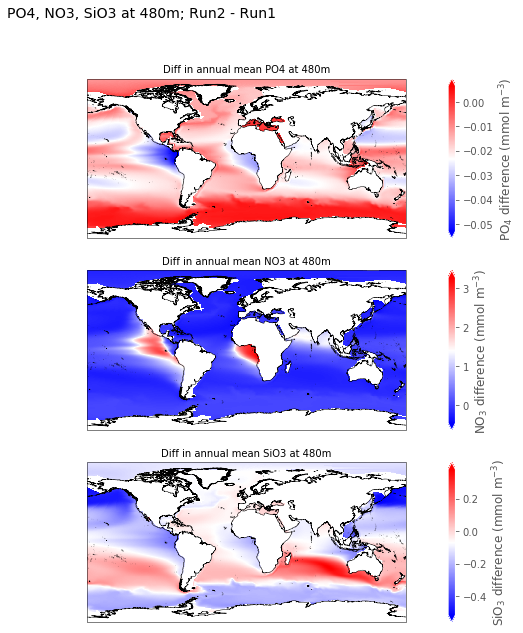

In [30]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('PO4, NO3, SiO3 at 480m; Run2 - Run1', fontsize=14)

#COLUMN 1  - PO4 diff
#---- 
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean PO4 at 480m', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.PO4.isel(z_t=32)-ds1_annmean.PO4.isel(z_t=32),cmap='bwr',
                 #vmin=0, vmax=300, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='PO$_4$ difference (mmol m$^{-3}$)')

#----  NO3 diff
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean NO3 at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.NO3.isel(z_t=32)-ds1_annmean.NO3.isel(z_t=32), cmap='bwr',
                 #vmin=0, vmax=300, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='NO$_3$ difference (mmol m$^{-3}$)')

#----  SiO3 diff
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Diff in annual mean SiO3 at 480m', fontsize=10)
pc2=ax.pcolormesh(lons, lats, 
                 ds2_annmean.SiO3.isel(z_t=32)-ds1_annmean.SiO3.isel(z_t=32), cmap='bwr',
                 #vmin=0, vmax=300, 
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc2, ax=ax,extend='both',label='SiO$_3$ difference (mmol m$^{-3}$)')

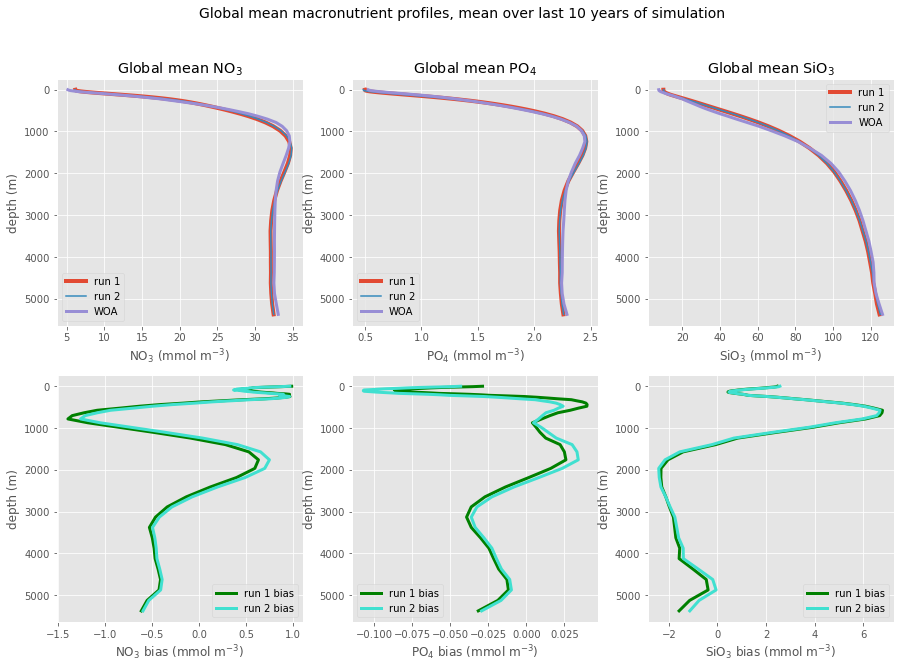

In [40]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Global mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Global mean NO$_3$')
ax.plot(ds1_glb['NO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_glb['NO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_glb_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Global mean PO$_4$')
ax.plot(ds1_glb['PO4'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_glb['PO4'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_glb_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Global mean SiO$_3$')
ax.plot(ds1_glb['SiO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_glb['SiO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_glb_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds1_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_glb['NO3'].values - ds_glb_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds1_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_glb['PO4'].values - ds_glb_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds1_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_glb['SiO3'].values - ds_glb_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



by major basin

In [42]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

Pacific

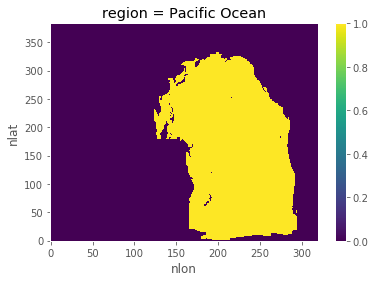

In [43]:
regnum=2
mask3d.isel(region=regnum).plot();

In [44]:
ds1_pac = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_pac['NO3']= esmlab.weighted_mean(ds1_annmean['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['PO4']= esmlab.weighted_mean(ds1_annmean['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['O2']= esmlab.weighted_mean(ds1_annmean['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_pac['AOU']= esmlab.weighted_mean(ds1_annmean['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [45]:
ds2_pac = xr.Dataset({v: ds2[v] for v in ['time', 'time_bound']})
ds2_pac['NO3']= esmlab.weighted_mean(ds2_annmean['NO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['PO4']= esmlab.weighted_mean(ds2_annmean['PO4']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['O2']= esmlab.weighted_mean(ds2_annmean['O2']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_pac['AOU']= esmlab.weighted_mean(ds2_annmean['AOU']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()

In [47]:
ds_pac_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_pac_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_pac_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

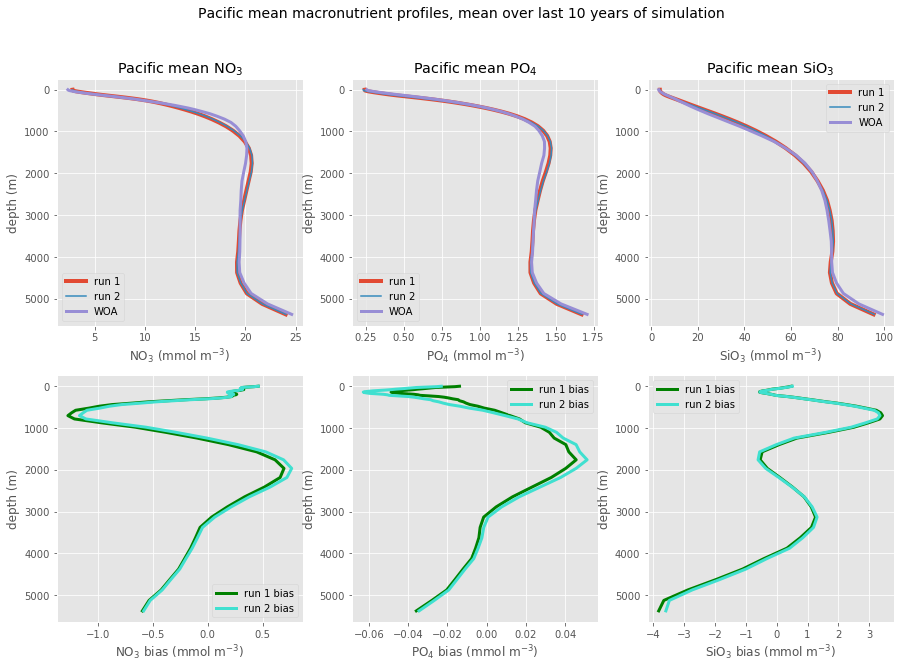

In [48]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Pacific mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific mean NO$_3$')
ax.plot(ds1_pac['NO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_pac['NO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_pac_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Pacific mean PO$_4$')
ax.plot(ds1_pac['PO4'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_pac['PO4'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_pac_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Pacific mean SiO$_3$')
ax.plot(ds1_pac['SiO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_pac['SiO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_pac_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds1_pac['NO3'].values - ds_pac_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_pac['NO3'].values - ds_pac_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds1_pac['PO4'].values - ds_pac_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_pac['PO4'].values - ds_pac_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds1_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_pac['SiO3'].values - ds_pac_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



Atlantic

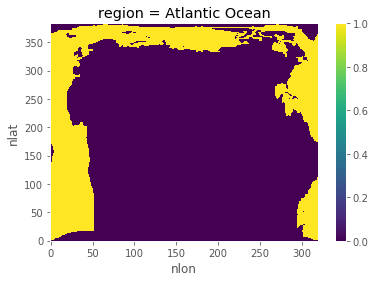

In [49]:
regnum=1
mask3d.isel(region=regnum).plot();

In [50]:
ds1_atl = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_atl['NO3']= esmlab.weighted_mean(ds1_annmean['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['PO4']= esmlab.weighted_mean(ds1_annmean['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['O2']= esmlab.weighted_mean(ds1_annmean['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_atl['AOU']= esmlab.weighted_mean(ds1_annmean['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [51]:
ds2_atl = xr.Dataset({v: ds2[v] for v in ['time', 'time_bound']})
ds2_atl['NO3']= esmlab.weighted_mean(ds2_annmean['NO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['PO4']= esmlab.weighted_mean(ds2_annmean['PO4']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['O2']= esmlab.weighted_mean(ds2_annmean['O2']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_atl['AOU']= esmlab.weighted_mean(ds2_annmean['AOU']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()

In [52]:
ds_atl_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_atl_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_atl_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

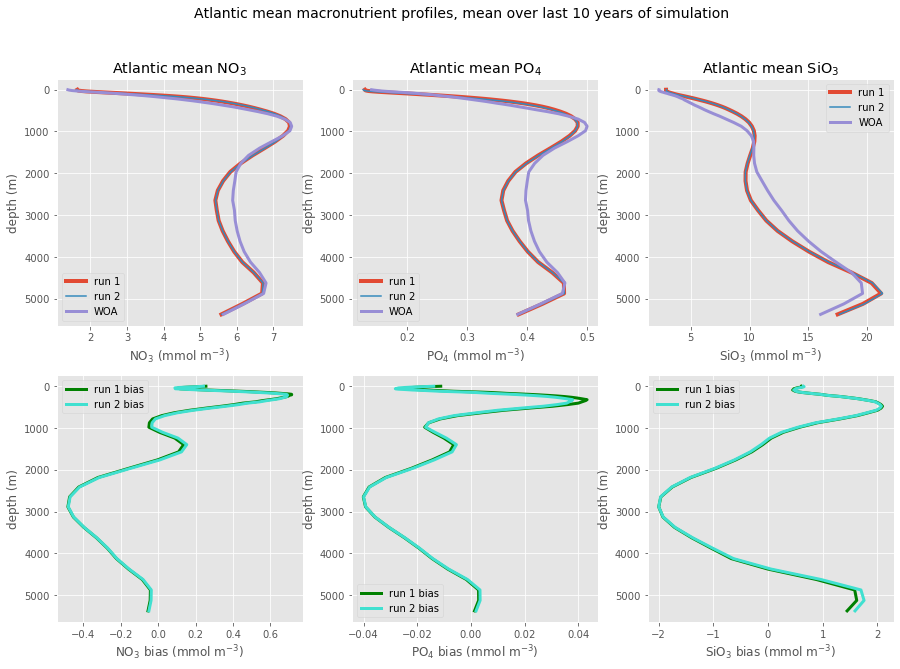

In [53]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Atlantic mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Atlantic mean NO$_3$')
ax.plot(ds1_atl['NO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_atl['NO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_atl_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Atlantic mean PO$_4$')
ax.plot(ds1_atl['PO4'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_atl['PO4'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_atl_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Atlantic mean SiO$_3$')
ax.plot(ds1_atl['SiO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_atl['SiO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_atl_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds1_atl['NO3'].values - ds_atl_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_atl['NO3'].values - ds_atl_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds1_atl['PO4'].values - ds_atl_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_atl['PO4'].values - ds_atl_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds1_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_atl['SiO3'].values - ds_atl_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()



Indian

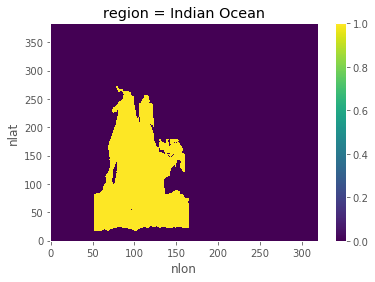

In [54]:
regnum=3
mask3d.isel(region=regnum).plot();

In [55]:
ds1_ind = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds1_ind['NO3']= esmlab.weighted_mean(ds1_annmean['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['PO4']= esmlab.weighted_mean(ds1_annmean['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['SiO3']= esmlab.weighted_mean(ds1_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['O2']= esmlab.weighted_mean(ds1_annmean['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds1_ind['AOU']= esmlab.weighted_mean(ds1_annmean['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [ ]:
ds2_ind = xr.Dataset({v: ds2[v] for v in ['time', 'time_bound']})
ds2_ind['NO3']= esmlab.weighted_mean(ds2_annmean['NO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['PO4']= esmlab.weighted_mean(ds2_annmean['PO4']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['SiO3']= esmlab.weighted_mean(ds2_annmean['SiO3']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['O2']= esmlab.weighted_mean(ds2_annmean['O2']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()
ds2_ind['AOU']= esmlab.weighted_mean(ds2_annmean['AOU']*mask3d.isel(region=regnum), weights=ds2.TAREA, dim=['nlat', 'nlon']).compute()

In [ ]:
ds_ind_woa = xr.Dataset({v: ds1[v] for v in ['time', 'time_bound']})
ds_ind_woa['NO3'] = esmlab.weighted_mean(ds_woa['NO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['PO4'] = esmlab.weighted_mean(ds_woa['PO4']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['SiO3'] = esmlab.weighted_mean(ds_woa['SiO3']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['O2'] = esmlab.weighted_mean(ds_woa['O2']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()
ds_ind_woa['AOU'] = esmlab.weighted_mean(ds_woa['AOU']*mask3d.isel(region=regnum), weights=ds1.TAREA, dim=['nlat', 'nlon']).compute()

In [ ]:
fig = plt.figure(figsize=(15,10))

plt.suptitle('Indian mean macronutrient profiles, mean over last 10 years of simulation', fontsize=14)


#COLUMN 1  - NO3

ax = fig.add_subplot(2,3,1)
ax.set_title('Indian mean NO$_3$')
ax.plot(ds1_ind['NO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_ind['NO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_ind_woa['NO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4

ax = fig.add_subplot(2,3,2)
ax.set_title('Indian mean PO$_4$')
ax.plot(ds1_ind['PO4'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_ind['PO4'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_ind_woa['PO4'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3

ax = fig.add_subplot(2,3,3)
ax.set_title('Indian mean SiO$_3$')
ax.plot(ds1_ind['SiO3'].values, depths, label='run 1', linewidth=4)
ax.plot(ds2_ind['SiO3'].values, depths, label='run 2', linewidth=1.5)
ax.plot(ds_ind_woa['SiO3'].values, depths, label='WOA', linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ (mmol m$^{-3}$)')
plt.gca().invert_yaxis()


#COLUMN 1  - NO3 diff

ax = fig.add_subplot(2,3,4)
ax.plot(ds1_ind['NO3'].values - ds_ind_woa['NO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_ind['NO3'].values - ds_ind_woa['NO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 2  - PO4 diff

ax = fig.add_subplot(2,3,5)
ax.plot(ds1_ind['PO4'].values - ds_ind_woa['PO4'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_ind['PO4'].values - ds_ind_woa['PO4'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='PO$_4$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

#COLUMN 3  - SiO3 diff

ax = fig.add_subplot(2,3,6)
ax.plot(ds1_ind['SiO3'].values - ds_ind_woa['SiO3'].values, depths, label='run 1 bias', linewidth=3, color='green')
ax.plot(ds2_ind['SiO3'].values - ds_ind_woa['SiO3'].values, depths, label='run 2 bias', linewidth=3, color='turquoise')
ax.legend()
ax.set(ylabel='depth (m)',xlabel='SiO$_3$ bias (mmol m$^{-3}$)')
plt.gca().invert_yaxis()

